In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import qiskit
from qiskit.quantum_info import Statevector, DensityMatrix, entropy
from qiskit.visualization import plot_circuit_layout, circuit_drawer
import pandas as pd
from matplotlib.pyplot import figure
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, assemble
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
import os
from qiskit import IBMQ
from qiskit.compiler import transpile
pi = np.pi
%matplotlib inline
IBMQ.save_account('47dfeff248e56fb0797c702b437981f906cc2eeac6ddd486fd0175142d5b37a7df5cd659692f49f41aa98b3503d96d62b0cb372c6bb65e95f53b132283931f1b')
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-11-30 12:02:20,691: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
#Callsical u3 calc
def U3(theta,phi):
  return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*phi)*np.cos(theta/2)]])

#numerical calculation of <Z>
def num_z(theta,phi):
  up = np.array([[1],[0]])
  IS = U3(theta,phi)
  PSI = np.matmul(IS,up)
  pauli_z = np.array([[1,0],[0,-1]])
  PSI_comp =np.matrix.getH(PSI)
  z_exp = np.matmul(PSI_comp,np.matmul(pauli_z,PSI))
  z = np.real(z_exp[0][0])
  return z

def CalM_sim(nqbit,ncbit,shots):
  Q0 = QuantumCircuit(nqbit,nqbit)
  Q1 = QuantumCircuit(nqbit,nqbit)
  Q1.x(nqbit-1)

  QC = [Q0,Q1]
  cm = []
  for qc in QC:
    qc.measure(0,0)
    provider = IBMQ.get_provider()
    backend = provider.get_backend('ibmq_bogota') #change based on QC one wants to use
    noise_model = NoiseModel.from_backend(backend)
    simulator = Aer.get_backend('qasm_simulator')
    counts = qiskit.execute(qc, backend=simulator, shots=shots, noise_model=noise_model).result().get_counts()
    cm.append(counts)
  return np.array([[cm[0]['0'],cm[1]['0']],[cm[0]['1'],cm[1]['1']]])/shots

def CalM_ibm(nqbit,ncbit,shots):
  Q0 = QuantumCircuit(nqbit,nqbit)
  Q1 = QuantumCircuit(nqbit,nqbit)
  Q1.x(0)

  QC = [Q0,Q1]

  cm = []
  for qc in QC:
    qc.measure(0,0)
    provider = IBMQ.get_provider().get_backend('ibmq_bogota') #change based on QC one wants to use
    new_QX = transpile(qc, backend=backend, optimization_level=0,initial_layout=[1]) #allocate physical qubit
    counts = qiskit.execute(new_QX, backend=provider, shots=shots).result().get_counts()
    cm.append(counts)
  return np.array([[cm[0]['0'],cm[1]['0']],[cm[0]['1'],cm[1]['1']]])/shots

In [5]:
shots = 8192
trails= 20
Theta = np.array([0,pi/6,pi/4,pi/3,pi/2,2*pi/3,3*pi/4,5*pi/6,pi])
Phi = np.array([pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4,2*pi])

z_trues =[]
thetas = []
phis = []

#list of our QC given theta and phi
QC_list= []
for i in range(len(Theta)): 
  for j in range(len(Phi)):
    z_trues.append(num_z(Theta[i],Phi[j]))
    qc=QuantumCircuit(1,1)
    qc.u3(Theta[i],Phi[j],0,0)
    qc.measure(0,0)
    QC_list.append(qc)
    thetas.append(Theta[i])
    phis.append(Phi[j])

<ipython-input-5-61bc6cefd437>:15: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(Theta[i],Phi[j],0,0)


ibmqfactory.load_account:WARNING:2021-11-30 12:02:33,094: Credentials are already in use. The existing account in the session will be replaced.


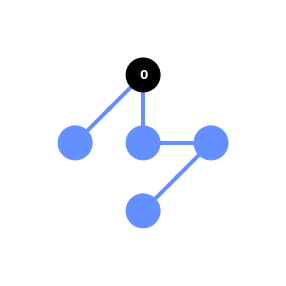

In [6]:
#using transpiler to allocate physical qubit
IBMQ.load_account()
backend = IBMQ.get_provider().get_backend('ibmq_bogota')
new_QC_list = []
for QC in QC_list:
    new_QC_list.append(transpile(QC, backend=backend, optimization_level=0,initial_layout=[1]))
plot_circuit_layout(new_QC_list[0], backend)

In [7]:
#saving images of circuits
for i,img in enumerate(new_QC_list):
  k = circuit_drawer(img,output='mpl')
  k.savefig(f'image_QC1_{i}.png')

In [8]:
#creating CM
CM = []
for i in range(trails):
   CM.append(CalM_ibm_5q(1,1,shots))
CM_ibm_5q =sum(CM)/trails

cc = pd.DataFrame()
for i in CM:
  df = pd.DataFrame(i)
  cc = cc.append(df)

#saving CM data
cc.to_csv('q1_CM_raw.csv',index=False)
CM_mean = pd.DataFrame(CM_ibm_5q)
CM_mean.to_csv('q1_CM_mean.csv',index=False)

<ipython-input-4-c6fff829b261>:78: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  QX = qc + Measure(qx,'Z',0,0)
C:\Users\danny\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [9]:
#running QC given CM 
ZM = []
Z_exp = []
for i in range(trails):
  zm = []
  z_exp = []
  provider = IBMQ.get_provider()
  backend = provider.get_backend('ibmq_bogota') #Change based on what QC one wants to use
  results = qiskit.execute(new_QC_list, backend=backend, shots=shots).result()
  
  for i in range(len(phis)):
    counts = results.get_counts(i)
    #raw data
    raw_count = np.array([[counts['0']],[counts['1']]])
    z_exp.append((counts['0']-counts['1'])/shots)
    #applying CM
    cal_prob = np.matmul(LA.inv(CM_ibm_5q),raw_count)/shots 
    zm.append(cal_prob[0]-cal_prob[1])
  ZM.append(zm)
  Z_exp.append(z_exp)

In [10]:
#saving data 
df2 = pd.DataFrame(ZM)
for i in df2.columns:
  df2[i]=[j[0] for j in df2[i]]

df3 = pd.DataFrame(Z_exp)

z_qcs = df3.mean(axis=0)
z_qcs_std =df3.std(axis=0)
z_ms = df2.mean(axis=0)
z_ms_std = df2.std(axis=0)

data_ibm_5q_q1 = pd.DataFrame({
    'theta':thetas,
    'phi':phis,
    'z_true':z_trues,
    'z_qc':z_qcs,
    'z_qc_std':z_qcs_std,
    'z_M':z_ms,
    'z_M_std':z_ms_std
    })
data_ibm_5q_q1.to_csv('data_ibm_5q_q1.csv',index=False)

data_qc_z_raw_ibm_5q_q1 = pd.DataFrame({
    'theta':thetas,
    'phi':phis,
    'z_qc_raw_1':Z_exp[0],
    'z_qc_raw_2':Z_exp[1],
    'z_qc_raw_3':Z_exp[2],
    'z_qc_raw_4':Z_exp[3],
    'z_qc_raw_5':Z_exp[4],
    'z_qc_raw_6':Z_exp[5],
    'z_qc_raw_7':Z_exp[6],
    'z_qc_raw_8':Z_exp[7],
    'z_qc_raw_9':Z_exp[8],
    'z_qc_raw_10':Z_exp[9],
    'z_qc_raw_11':Z_exp[10],
    'z_qc_raw_12':Z_exp[11],
    'z_qc_raw_13':Z_exp[12],
    'z_qc_raw_14':Z_exp[13],
    'z_qc_raw_15':Z_exp[14],
    'z_qc_raw_16':Z_exp[15],
    'z_qc_raw_17':Z_exp[16],
    'z_qc_raw_18':Z_exp[17],
    'z_qc_raw_19':Z_exp[18],
    'z_qc_raw_20':Z_exp[19],
    })
data_qc_z_raw_ibm_5q_q1.to_json('data_qc_z_raw_ibm_5q_q1.json')

data_ZM_raw_ibm_5q_q1 = pd.DataFrame({
    'theta':thetas,
    'phi':phis,
    'z_ZM_raw_1':ZM[0],
    'z_ZM_raw_2':ZM[1],
    'z_ZM_raw_3':ZM[2],
    'z_ZM_raw_4':ZM[3],
    'z_ZM_raw_5':ZM[4],
    'z_ZM_raw_6':ZM[5],
    'z_ZM_raw_7':ZM[6],
    'z_ZM_raw_8':ZM[7],
    'z_ZM_raw_9':ZM[8],
    'z_ZM_raw_10':ZM[9],
    'z_ZM_raw_11':ZM[10],
    'z_ZM_raw_12':ZM[11],
    'z_ZM_raw_13':ZM[12],
    'z_ZM_raw_14':ZM[13],
    'z_ZM_raw_15':ZM[14],
    'z_ZM_raw_16':ZM[15],
    'z_ZM_raw_17':ZM[16],
    'z_ZM_raw_18':ZM[17],
    'z_ZM_raw_19':ZM[18],
    'z_ZM_raw_20':ZM[19],
    })
data_ZM_raw_ibm_5q_q1.to_json('data_ZM_raw_ibm_5q_q1.json')
os.getcwd()

'C:\\Users\\danny'